Figure 7 data analysis
============

Get info about Octave and it's packages:

In [1]:
ver ('Octave');
pkg list;
pkg describe -verbose statistics-resampling

----------------------------------------------------------------------
GNU Octave Version: 8.3.0 (hg id: 6fc591af58ba)
GNU Octave License: GNU General Public License
Operating System: Linux 5.15.0-94-generic #104-Ubuntu SMP Tue Jan 9 15:25:40 UTC 2024 x86_64
----------------------------------------------------------------------
Package Name           | Version | Installation directory
-----------------------+---------+-----------------------
                coder  |   1.9.1 | .../octave/api-v58/packages/coder-1.9.1
              control  |   4.0.0 | .../octave/api-v58/packages/control-4.0.0
       data-smoothing  |   1.3.0 | .../api-v58/packages/data-smoothing-1.3.0
            dataframe  |   1.2.0 | .../octave/api-v58/packages/dataframe-1.2.0
               fileio  |   1.2.2 | .../octave/api-v58/packages/fileio-1.2.2
                   ga  |  0.10.3 | .../share/octave/api-v58/packages/ga-0.10.3
                   io *|   2.6.4 | .../share/octave/api-v58/packages/io-2.6.4
        misce

Load the data:

In [2]:
load ('../data/data.mat', '-v7')
format short g

Define functions to compute Matthews Correlation Coefficient scores (off-diagonal elements only) for pairwise comparisons, within blocks of length `m`, between event times in cell indices `a` and `b` from `data.fig7.EventTimes`:

In [3]:
% Define bespoke function to compute MCC scores between event times in cells with indices a and b in data.fig7.EventTimes
function MCC = MCCscores (data, a, b)

  % This reproduces the MCCs in Oli's figure
  % Get data
  x  = data.fig7.EventTimes{a};            % Get x (reference)
  nx = numel (x);                          % Number of events detected in x
  y  = data.fig7.EventTimes{b};            % Get y (test) 
  ny = numel (y);                          % Number of events detected in y

  % Number of possible test detections in reference
  N  = repmat (data.fig7.N_4SD, 1, 2);
  N  = N(a);

  % Find matching event times
  % The ismembertol function was intoducd in the newer, Octave 9, so the function file has been provided in this repo
  tol = 0.00004;                  % Tolerance for identical event times (in seconds)
  L   = ismembertol (y, x, tol);  % Vector of logical indices of matching event times

  % Compute statistics
  TP  = sum (L);                  % Number of reference events within tolerance of one or more detected events
  FP  = ny - TP;                  % Number of test detections  - the number of true positives
  FN  = nx - TP;                  % Number of reference events - the number of true positives
  TN  = N - ny - FN;              % Number of possible test detections - number of detections - number of false negatives
  MCC = (TP * TN - FP * FN) / ...
         sqrt ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN));
       
end

% Generate pairwise comparisons for every group of m number of users
% The 15 rows in data.fig7.EventTimes contain data for 3 recordings each analysed by 5 users.
% Rows 1:5 are for 5 users analysing the first recording
% Rows 6:10 are for 5 users analysing the second recording
% Rows 11:15 are for 5 users analysing the third recording
% Therefore, m is set to 5
% Indices in 'a' point to data used as the reference, indices in 'b' point to data used as the test
m = 5;
q = logical (tril (ones (m, m), -1));
i = uint32 (ones (m,1) * (1:m));
j = uint32 ((1:m)' * ones (1, m));
o = ones (m^2 - m, 1) * (0: 5: 15 - 1);
idx = bsxfun (@plus, repmat ([i(q), j(q); j(q),i(q)],3, 1), o(:));
a = double (cat (1, idx(:,1)));
b = double (cat (1, idx(:,2)));

% Create anonymous function(s) to compute pairwise MCC scores given indices for the cells in data.fig7.EventTimes
anon_MCCscores = @(a,b) MCCscores (data, a, b);
pairwise_MCCscores = @(i) arrayfun (anon_MCCscores, i(a), i(b));

Create table of MCC scores per person:

In [4]:
% Compute pairwise MCC scores between users using either manual (MAN) or machine learning model classification (MLM)
i = (1:15)';
j = (16:30)';
MCC_MAN = pairwise_MCCscores(i);
MCC_MLM = pairwise_MCCscores(j);

% Create table of MCCs
fprintf ('--------------------------------------------\n')
fprintf ('|       Manual        |  Machine Learning  |\n')
header = {'Cell no.', 'MCC', 'Cell no.', 'MCC'};
tbl = table ([i(a), i(b)], MCC_MAN, [j(a), j(b)], MCC_MLM);
tbl = setVariableNames (tbl, (1:4), header);
prettyprint (tbl(:,:))

% Average MCC scores
fprintf ('Mean MCC of events detected between users using manual classification: %.2f\n', mean (MCC_MAN))
fprintf ('Mean MCC of events detected between users using machine learning classification: %.2f\n', mean (MCC_MLM))
fprintf ('Difference in the mean MCC between machine learning and manual classification: %.2f', mean (MCC_MLM) - mean (MCC_MAN))

% Save results
MCC = struct;
MCC.MAN = [i(a), i(b), MCC_MAN];
MCC.MLM = [j(a), j(b), MCC_MLM];
save ('../output/mcc_results.mat', 'MCC', '-v7')

--------------------------------------------
|       Manual        |  Machine Learning  |
--------------------------------------------
| Cell no. | MCC      | Cell no. | MCC     |
--------------------------------------------
| 1   2    | 0.41737  | 16   17  | 0.67614 |
| 1   3    | 0.66071  | 16   18  | 0.88172 |
| 1   4    | 0.68732  | 16   19  | 0.91073 |
| 1   5    | 0.64227  | 16   20  | 0.83742 |
| 2   3    | 0.31644  | 17   18  | 0.77039 |
| 2   4    | 0.40012  | 17   19  | 0.68714 |
| 2   5    | 0.29531  | 17   20  | 0.63962 |
| 3   4    | 0.60491  | 18   19  | 0.79468 |
| 3   5    | 0.5228   | 18   20  | 0.7327  |
| 4   5    | 0.60224  | 19   20  | 0.87005 |
| 2   1    | 0.44096  | 17   16  | 0.69639 |
| 3   1    | 0.66071  | 18   16  | 0.88172 |
| 4   1    | 0.68309  | 19   16  | 0.90757 |
| 5   1    | 0.6398   | 20   16  | 0.83442 |
| 3   2    | 0.27667  | 18   17  | 0.75627 |
| 4   2    | 0.34934  | 19   17  | 0.6576  |
| 5   2    | 0.24082  | 20   17  | 0.6088  |
| 4   3   

Perform permutation test with the null hypothesis that the average MCC scores between users is the same for user classification as it is for classification using a common machine learning model. Note that with a large `nreps`, this step takes a long time so we save the output to reload it in subsequent analysis steps. Nota that setting `nreps` for paired permutations to `2^n`, where n is the number of rows (i.e. users, in this case 15) gives an exact permutation test (in which case, the `seed` argument is ignored).

In [ ]:
help randtest2
seed = 1;
nreps = 2^15; % Disables randomization and systematically computes all 32768 permutations
%nreps = 20000;
[PVAL, STAT, FPR, PERMSTAT] = randtest2 (i, j, true, nreps, @(i, j) mean (pairwise_MCCscores(j)) - ...
                                                                    mean (pairwise_MCCscores(i)), seed);                                                               
save ('../output/randtest2_output.mat', 'PVAL', 'STAT', 'FPR', 'PERMSTAT', '-v7')

'randtest2' is a function from the file /home/jovyan/.local/share/octave/api-v58/packages/statistics-resampling-5.5.10/randtest2.m

 Performs a permutation or randomization test to compare the distributions of 
 two independent or paired data samples. 

 -- Function File: PVAL = randtest2 (A, B)
 -- Function File: PVAL = randtest2 (A, B, PAIRED)
 -- Function File: PVAL = randtest2 (A, B, PAIRED, NREPS)
 -- Function File: PVAL = randtest2 (A, B, PAIRED, NREPS)
 -- Function File: PVAL = randtest2 (A, B, PAIRED, NREPS, FUNC)
 -- Function File: PVAL = randtest2 (A, B, PAIRED, NREPS, FUNC, SEED)
 -- Function File: PVAL = randtest2 ([A, GA], [B, GB], ...)
 -- Function File: [PVAL, STAT] = randtest2 (...)
 -- Function File: [PVAL, STAT, FPR] = randtest2 (...)
 -- Function File: [PVAL, STAT, FPR, PERMSTAT] = randtest2 (...)

     'PVAL = randtest2 (A, B)' performs a randomization (or permutation) test
     to ascertain whether data samples A and B come from populations with
     the same distr

In [5]:
% Load the permutation test results
load ('../output/randtest2_output.mat', '-v7')

% Print text summary of permutation test statistics
fprintf ('Difference in mean pairwise MCC scores between manual and machine learning classification: %.3f\n', STAT)
fprintf ('Number of randomized sample replicates : %d\n', numel (PERMSTAT))
fprintf ('Randomization test p-value (2-tailed): %.5f\n', PVAL)
fprintf ('False positive risk: %.5f\n', FPR)

Difference in mean pairwise MCC scores between manual and machine learning classification: 0.310
Number of randomized sample replicates : 5000
Randomization test p-value (2-tailed): 0.00040
False positive risk: 0.00844


In [6]:
% Create matrices of MCCs for manual classification between students in each of the three groups
MAN_MAT = struct;
m = 5;
MAN_MAT.A = ones (m);
MAN_MAT.A(sub2ind ([m,m],MCC.MAN(1:10,1)  - 0 * m, MCC.MAN(1:10,2)  - 0 * m)) = MCC.MAN(1:10,3);
MAN_MAT.A(sub2ind ([m,m],MCC.MAN(11:20,1) - 0 * m, MCC.MAN(11:20,2) - 0 * m)) = MCC.MAN(11:20,3);
MAN_MAT.B = ones (m);
MAN_MAT.B(sub2ind ([m,m],MCC.MAN(21:30,1) - 1 * m, MCC.MAN(21:30,2) - 1 * m)) = MCC.MAN(21:30,3);
MAN_MAT.B(sub2ind ([m,m],MCC.MAN(31:40,1) - 1 * m, MCC.MAN(31:40,2) - 1 * m)) = MCC.MAN(31:40,3);
MAN_MAT.C = ones (m);
MAN_MAT.C(sub2ind ([m,m],MCC.MAN(41:50,1) - 2 * m, MCC.MAN(41:50,2) - 2 * m)) = MCC.MAN(41:50,3);
MAN_MAT.C(sub2ind ([m,m],MCC.MAN(51:60,1) - 2 * m, MCC.MAN(51:60,2) - 2 * m)) = MCC.MAN(51:60,3);

% Sanity check our matrices
MAN_MAT.A
MAN_MAT.B
MAN_MAT.C

ans =

            1      0.41737      0.66071      0.68732      0.64227
      0.44096            1      0.31644      0.40012      0.29531
      0.66071      0.27667            1      0.60491       0.5228
      0.68309      0.34934      0.59719            1      0.60224
       0.6398      0.24082      0.51796      0.60655            1

ans =

            1      0.58596      0.45606      0.48791      0.60702
      0.59733            1       0.5778      0.38668       0.4609
      0.46499      0.56445            1       0.2441      0.38222
      0.50186      0.39751      0.26957            1      0.48228
      0.59252      0.42045      0.33657      0.45556            1

ans =

            1      0.48613     0.027669       0.4854      0.38323
      0.53803            1      0.17119      0.55203       0.5438
      0.21994      0.15218            1       0.1974       0.1573
      0.52353      0.54276       0.1805            1      0.48179
       0.4397       0.5438      0.17411      0.49138 

In [7]:
% Create matrices of MCCs for machine learning classification between students in each of the three groups
MLM_MAT = struct;
m = 5;
MLM_MAT.A = ones (m);
MLM_MAT.A(sub2ind ([m,m],MCC.MLM(1:10,1)  - 3 * m, MCC.MLM(1:10,2)  - 3 * m)) = MCC.MLM(1:10,3);
MLM_MAT.A(sub2ind ([m,m],MCC.MLM(11:20,1) - 3 * m, MCC.MLM(11:20,2) - 3 * m)) = MCC.MLM(11:20,3);
MLM_MAT.B = ones (m);
MLM_MAT.B(sub2ind ([m,m],MCC.MLM(21:30,1) - 4 * m, MCC.MLM(21:30,2) - 4 * m)) = MCC.MLM(21:30,3);
MLM_MAT.B(sub2ind ([m,m],MCC.MLM(31:40,1) - 4 * m, MCC.MLM(31:40,2) - 4 * m)) = MCC.MLM(31:40,3);
MLM_MAT.C = ones (m);
MLM_MAT.C(sub2ind ([m,m],MCC.MLM(41:50,1) - 5 * m, MCC.MLM(41:50,2) - 5 * m)) = MCC.MLM(41:50,3);
MLM_MAT.C(sub2ind ([m,m],MCC.MLM(51:60,1) - 5 * m, MCC.MLM(51:60,2) - 5 * m)) = MCC.MLM(51:60,3);

% Sanity check our matrices
MLM_MAT.A
MLM_MAT.B
MLM_MAT.C

ans =

            1      0.67614      0.88172      0.91073      0.83742
      0.69639            1      0.77039      0.68714      0.63962
      0.88172      0.75627            1      0.79468       0.7327
      0.90757       0.6576      0.78853            1      0.87005
      0.83442       0.6088      0.72857      0.87253            1

ans =

            1      0.92614      0.74015       0.9702      0.67699
      0.92796            1      0.77183      0.95575      0.70729
      0.74383       0.7682            1      0.76639      0.88566
      0.97159      0.95683      0.77606            1      0.71603
      0.65537      0.67425      0.87063      0.67744            1

ans =

            1      0.55577      0.65238      0.81212      0.77559
      0.60869            1      0.50622      0.66954        0.667
      0.67128      0.50244            1        0.617      0.64022
      0.82839      0.65998      0.61434            1      0.86979
      0.79921        0.667      0.64261      0.87298 

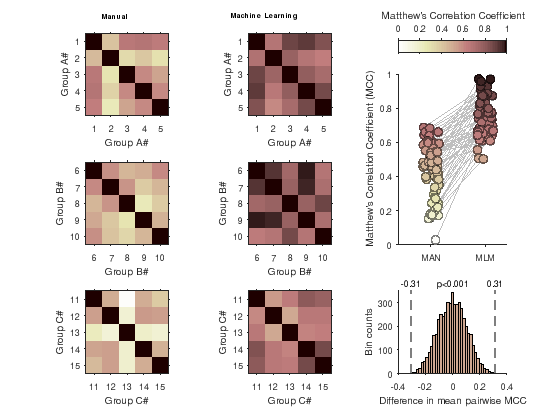

In [8]:
% Create figure with subplots containing each of the heatmaps
h_fig7 = figure (1);
set (gcf, 'color')

% Create heatmap plot for group A manual classification
h_sp1 = subplot (3, 3, 1);
pos1 = get (h_sp1, 'position');
pos1(1) = pos1(1) + 0.05;
pos1(2) = 0.95;
annotation ('textbox', pos1, 'string', 'Manual', 'linestyle', 'none', ...
                             'fontweight', 'bold', 'fontsize', 9)
imagesc(MAN_MAT.A)
axis (gca, 'square')
set (gca, 'xlabel', 'Group A#', 'ylabel', 'Group A#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis([0 1])

% Create heatmap plot for group A machine learning classification
h_sp2 = subplot (3, 3, 2);
pos2 = get (h_sp2, 'position');
pos2(1) = pos2(1) - 0.01;
pos2(2) = 0.95;
annotation ('textbox', pos2, 'string', 'Machine Learning', 'linestyle', ...
                             'none', 'fontweight', 'bold', 'fontsize', 9)
imagesc (MLM_MAT.A)
axis (gca, 'square')
set (gca, 'xlabel', 'Group A#', 'ylabel', 'Group A#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis ([0 1])

% Create scatter plot for MCC for each subject and condition with heatmap color bar
subplot (3, 3, [3, 6]);
colormap (flipud (pink));
caxis ([0 1])
HCB = colorbar ('location', 'northoutside');
rand ('twister', 2);
xjitter = bsxfun (@plus, cat (1, zeros (60,1), ones (60,1)), 0.3 * (rand (120, 1) - 0.5));
y = cat (1, MCC_MAN, MCC_MLM);
hold on; arrayfun (@(i) line ([xjitter(i),xjitter(60+i)], [y(i),y(60+i)], ...
                              'color', [0.75,0.75,0.75]), 1 : 60)
scatter (xjitter, y, 72, y, 'filled', 'markeredgecolor', 'k', 'linewidth', 0.25, ...
                                      'markeredgealpha', 0.5); hold off;
set (gca, 'xlim', [-0.6 1.4], 'xtick', [0, 1], 'xticklabel', {'MAN', 'MLM'}, ...
          'ylabel', 'Matthew''s Correlation Coefficient (MCC)', 'alphamap', 0.5, 'tickdir', 'out')
set (HCB, 'xlabel', 'Matthew''s Correlation Coefficient', 'tickdir', 'out')

% Create heatmap plot for group B manual classification
subplot (3, 3, 4)
imagesc (MAN_MAT.B)
axis (gca, 'square')
set (gca, 'yticklabel', cellfun (@num2str, num2cell (6:10), 'UniformOutput', false), ...
          'xticklabel', cellfun (@num2str, num2cell (6:10), 'UniformOutput', false), ...
          'xlabel', 'Group B#', 'ylabel', 'Group B#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis ([0 1])

% Create heatmap plot for group B machine learning classification
subplot (3, 3, 5)
imagesc (MLM_MAT.B)
axis (gca, 'square')
set (gca, 'yticklabel', cellfun (@num2str, num2cell (6:10), 'UniformOutput', false), ...
          'xticklabel', cellfun (@num2str, num2cell (6:10), 'UniformOutput', false), ...
          'xlabel', 'Group B#', 'ylabel', 'Group B#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis ([0 1])

% Create heatmap plot for group C manual classification
subplot (3, 3, 7)
imagesc (MAN_MAT.C)
axis (gca, 'square')
set (gca, 'yticklabel', cellfun (@num2str, num2cell (11:15), 'UniformOutput', false), ...
          'xticklabel', cellfun (@num2str, num2cell (11:15), 'UniformOutput', false), ...
          'xlabel', 'Group C#', 'ylabel', 'Group C#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis ([0 1])

% Create heatmap plot for group C machine learning classification
subplot (3, 3, 8);
imagesc (MLM_MAT.C)
axis (gca, 'square')
set (gca, 'yticklabel', cellfun (@num2str, num2cell (11:15), 'UniformOutput', false), ...
          'xticklabel', cellfun (@num2str, num2cell (11:15), 'UniformOutput', false), ...
          'xlabel', 'Group C#', 'ylabel', 'Group C#', 'tickdir', 'out');
colormap (gca, flipud (pink))
caxis ([0 1])

% Plot permutation distribution
subplot (3, 3, 9)
h = 2 * iqr (PERMSTAT) * numel (PERMSTAT)^(- 1 / 3); % Freedman-Diaconis rule
nbins = ceil (range (PERMSTAT) / h);
hist (PERMSTAT, nbins);
line (+ STAT * ones (1, 2), ylim, 'color', [0.5,0.5,0.5], 'linewidth', 1, 'linestyle','--')
line (- STAT * ones (1, 2), ylim, 'color', [0.5,0.5,0.5], 'linewidth', 1, 'linestyle','--')
text (- STAT, 400, num2str (- STAT, 2), 'horizontalalignment', 'center', 'verticalalignment', 'top')
text (+ STAT, 400, num2str (+ STAT, 2), 'horizontalalignment', 'center', 'verticalalignment', 'top')
text (0, 400, 'p<0.001', 'horizontalalignment', 'center', 'verticalalignment', 'top')
ylabel ('Bin counts');
xlabel ('Difference in mean pairwise MCC');
set (gca, 'tickdir', 'out', 'ytick', [0:100:400])
box off

% Save plots
print ('../output/fig7.png', '-dpng', '-S960,720')